In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer
import torch


2025-02-06 12:44:38.951344: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 12:44:38.972097: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-06 12:44:39.168853: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-06 12:44:39.170575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-06 12:44:39.737699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# Define column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

# Drop the 'difficulty_degree' column
train.drop("difficulty_degree", axis=1, inplace=True)
test.drop("difficulty_degree", axis=1, inplace=True)

# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Convert labels to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize numerical features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert each row into a string format for tokenization (Bloom needs text inputs)
train_sequences = [" ".join(map(str, row)) for row in X_train]
test_sequences = [" ".join(map(str, row)) for row in X_test]


In [3]:
# Load Bloom tokenizer
model_name = "bigscience/bloom-1b7"  # You can use larger versions if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize dataset
train_encodings = tokenizer(train_sequences, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_sequences, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Convert labels to PyTorch tensors
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Create PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], y_train)
test_dataset = torch.utils.data.TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], y_test)

# Create PyTorch dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)


In [7]:
import torch.nn as nn
import torch.optim as optim

# Load pre-trained Bloom model for embeddings
bloom_model = AutoModel.from_pretrained("bigscience/bloom-1b7")

# Define a classification model with Bloom embeddings
class BloomIDSModel(nn.Module):
    def __init__(self, bloom_model):
        super(BloomIDSModel, self).__init__()
        self.bloom = bloom_model
        self.fc = nn.Linear(2048, 2)  # Change from 1024 to 2048

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bloom(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use CLS token representation
        return self.fc(pooled_output)

# Initialize model
model = BloomIDSModel(bloom_model)

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 490.00 MiB. GPU 0 has a total capacity of 7.68 GiB of which 78.31 MiB is free. Process 2860 has 155.06 MiB memory in use. Including non-PyTorch memory, this process has 6.81 GiB memory in use. Of the allocated memory 6.61 GiB is allocated by PyTorch, and 11.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_dataset)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Train Accuracy: {train_acc:.4f}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 7.68 GiB of which 42.94 MiB is free. Process 2860 has 155.06 MiB memory in use. Including non-PyTorch memory, this process has 6.81 GiB memory in use. Of the allocated memory 6.61 GiB is allocated by PyTorch, and 11.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

NameError: name 'history' is not defined

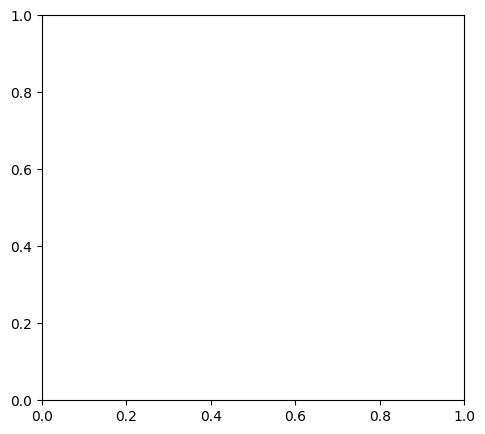

In [7]:
model.eval()
correct = 0
y_pred = []
y_true = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask)
        predictions = outputs.argmax(1)

        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Compute accuracy
test_acc = np.mean(np.array(y_pred) == np.array(y_true))
print(f"Test Accuracy: {test_acc:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig("Bloom_Confusion-Matrix.png")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=["Attack", "Normal"]))


In [8]:
# Generate predictions
y_pred = tf.argmax(model.predict(test_dataset).logits, axis=1).numpy()

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig("Bloom_Confusion-Matrix.png")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))


NameError: name 'model' is not defined

In [9]:
# Compute ROC Curve
y_pred_proba = tf.nn.softmax(model.predict(test_dataset).logits)[:, 1].numpy()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig("Bloom_ROC-Curve.png")
plt.show()


NameError: name 'model' is not defined